# Initialize

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from torch.distributions import Categorical
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader

from model import VAE_priorCategorical, VAE_priorHFM
import metadata as md
from train import train
from datasets import Dataset_HFM, Dataset_pureHFM
from utilities import sample_images
from find_gauge import get_feature_frequencies_sorted

In [20]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Utilizzo Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Utilizzo NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("Utilizzo la CPU")

device = torch.device('cpu')

if device.type == "cuda": 
    torch.cuda.manual_seed(md.seed)
elif device.type == "mps": 
    torch.mps.manual_seed(md.seed)

Utilizzo Apple Silicon GPU (MPS)


# Datasets

## train over MNIST

In [18]:
train_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=md.batch_size,
    shuffle=True
    )

val_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=md.batch_size,
    shuffle=False
    )

## train over FashionMNIST

In [5]:
train_loader_FashionMNIST = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=md.batch_size,
    shuffle=True
    )

val_loader_FashionMNIST = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=md.batch_size,
    shuffle=False
    )

## train over pureHFM

In [6]:
dataset_HFM_train = Dataset_pureHFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM/512features/glog2_train60000.pt',
                        root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

train_loader_pureHFM = DataLoader(
    dataset_HFM_train,
    batch_size=md.batch_size,
    shuffle=True
)

dataset_HFM_val = Dataset_pureHFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM/512features/glog2_validation10000.pt',
                            root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

val_loader_pureHFM = DataLoader(
    dataset_HFM_val, # Importante: usa dataset_HFM_val qui, non dataset_HFM
    batch_size=md.batch_size,
    shuffle=False
)

## train over expandedHFM

In [6]:
dataset_HFM_train = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/16_1024features/2hl_glog2_train60000.pt',
                        root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

train_loader_expandedHFM = DataLoader(
    dataset_HFM_train,
    batch_size=md.batch_size,
    shuffle=True
)

dataset_HFM_val = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/16_1024features/2hl_glog2_validation10000.pt',
                            root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

val_loader_expandedHFM = DataLoader(
    dataset_HFM_val, # Importante: usa dataset_HFM_val qui, non dataset_HFM
    batch_size=md.batch_size,
    shuffle=False
)

## train over expandedHFM 32-1024

In [5]:
dataset_HFM_train = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/32_1024features/2hl_glog2_train60000.pt',
                        root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

train_loader_expandedHFM_32_1024 = DataLoader(
    dataset_HFM_train,
    batch_size=md.batch_size,
    shuffle=True
)

dataset_HFM_val = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/32_1024features/2hl_glog2_validation10000.pt',
                            root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

val_loader_expandedHFM_32_1024 = DataLoader(
    dataset_HFM_val, # Importante: usa dataset_HFM_val qui, non dataset_HFM
    batch_size=md.batch_size,
    shuffle=False
)

# Prior Categorical

## train over MNIST

In [7]:
train_loader = train_loader_MNIST
val_loader = val_loader_MNIST
input_dim = 784

### latent_dim = 8


In [8]:

#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/MNIST/prior_Categorical/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 387.2214
Epoch: 1/15, Average loss: 273.8701
Epoch: 2/15, Average loss: 226.0219
Epoch: 3/15, Average loss: 198.7820
Epoch: 4/15, Average loss: 179.1189
Epoch: 5/15, Average loss: 165.0554
Epoch: 6/15, Average loss: 155.2160
Epoch: 7/15, Average loss: 147.9891
Epoch: 8/15, Average loss: 142.7795
Epoch: 9/15, Average loss: 138.7503
Epoch: 10/15, Average loss: 135.5485
Epoch: 11/15, Average loss: 132.9366
Epoch: 12/15, Average loss: 130.8681
Epoch: 13/15, Average loss: 129.1318
Epoch: 14/15, Average loss: 127.7810
Training completato e dati scritti su tensorboard
Parameters saved


In [14]:
#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/MNIST/ld8_glog2_ep15_lmb1_dr05_gKLlog2_NL_2hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld8_glog2_ep15_lmb1_dr05_gKLlog2_NL_2hl_0.pth')
print('Parameters saved')


#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/MNIST/ld8_glog2_ep15_lmb1_dr05_gKLlog2_NL_3hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld8_glog2_ep15_lmb1_dr05_gKLlog2_NL_3hl_0.pth')
print('Parameters saved')


#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/MNIST/ld8_glog2_ep15_lmb1_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld8_glog2_ep15_lmb1_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')



Epoch: 0/15, Average loss: 389.5810
Epoch: 1/15, Average loss: 272.9245
Epoch: 2/15, Average loss: 224.3924
Epoch: 3/15, Average loss: 196.1950
Epoch: 4/15, Average loss: 175.8703
Epoch: 5/15, Average loss: 161.4573
Epoch: 6/15, Average loss: 151.1268
Epoch: 7/15, Average loss: 143.5675
Epoch: 8/15, Average loss: 137.9279
Epoch: 9/15, Average loss: 133.4935
Epoch: 10/15, Average loss: 130.0795
Epoch: 11/15, Average loss: 127.3539
Epoch: 12/15, Average loss: 125.0256
Epoch: 13/15, Average loss: 123.2869
Epoch: 14/15, Average loss: 121.7311
Training completato e dati scritti su tensorboard
Parameters saved
Epoch: 0/15, Average loss: 396.2289
Epoch: 1/15, Average loss: 274.0455
Epoch: 2/15, Average loss: 225.6387
Epoch: 3/15, Average loss: 197.5839
Epoch: 4/15, Average loss: 177.1822
Epoch: 5/15, Average loss: 162.4309
Epoch: 6/15, Average loss: 152.1034
Epoch: 7/15, Average loss: 144.3967
Epoch: 8/15, Average loss: 138.8854
Epoch: 9/15, Average loss: 134.5667
Epoch: 10/15, Average loss: 

Epoch: 0/15, Average loss: 406.1312
Epoch: 1/15, Average loss: 286.6929
Epoch: 2/15, Average loss: 245.0724
Epoch: 3/15, Average loss: 228.9505
Epoch: 4/15, Average loss: 220.6820
Epoch: 5/15, Average loss: 215.7933
Epoch: 6/15, Average loss: 212.7011
Epoch: 7/15, Average loss: 210.6946
Epoch: 8/15, Average loss: 209.3343
Epoch: 9/15, Average loss: 208.4053
Epoch: 10/15, Average loss: 207.7541
Epoch: 11/15, Average loss: 207.2952
Epoch: 12/15, Average loss: 206.9622
Epoch: 13/15, Average loss: 206.7289
Epoch: 14/15, Average loss: 206.5564
Training completato e dati scritti su tensorboard
Parameters saved
Epoch: 0/15, Average loss: 406.1138
Epoch: 1/15, Average loss: 287.0436
Epoch: 2/15, Average loss: 245.4392
Epoch: 3/15, Average loss: 229.2813
Epoch: 4/15, Average loss: 220.8981
Epoch: 5/15, Average loss: 215.9010
Epoch: 6/15, Average loss: 212.7603
Epoch: 7/15, Average loss: 210.7333
Epoch: 8/15, Average loss: 209.3567
Epoch: 9/15, Average loss: 208.4134
Epoch: 10/15, Average loss: 

In [ ]:

#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.55, g_HFM per KL = log2, hidden layers = 5

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/MNIST/ld8_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld8_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 395.7954
Epoch: 1/15, Average loss: 273.6304
Epoch: 2/15, Average loss: 224.9896
Epoch: 3/15, Average loss: 197.5184
Epoch: 4/15, Average loss: 177.4550
Epoch: 5/15, Average loss: 163.1144
Epoch: 6/15, Average loss: 153.2959
Epoch: 7/15, Average loss: 146.2907
Epoch: 8/15, Average loss: 141.3657
Epoch: 9/15, Average loss: 137.5538
Epoch: 10/15, Average loss: 134.8549
Epoch: 11/15, Average loss: 132.4067
Epoch: 12/15, Average loss: 130.7438
Epoch: 13/15, Average loss: 129.3027
Epoch: 14/15, Average loss: 127.9742
Training completato e dati scritti su tensorboard
Parameters saved
Epoch: 0/15, Average loss: 404.6317
Epoch: 1/15, Average loss: 286.6195
Epoch: 2/15, Average loss: 245.0425
Epoch: 3/15, Average loss: 228.9936
Epoch: 4/15, Average loss: 220.7149
Epoch: 5/15, Average loss: 215.8072
Epoch: 6/15, Average loss: 212.7196
Epoch: 7/15, Average loss: 210.7017
Epoch: 8/15, Average loss: 209.3442
Epoch: 9/15, Average loss: 208.4157
Epoch: 10/15, Average loss: 

In [23]:

#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/MNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth')
print('Parameters saved')

Epoch: 0/15, Average loss: 398.0999
Epoch: 1/15, Average loss: 274.7463
Epoch: 2/15, Average loss: 225.8005
Epoch: 3/15, Average loss: 198.8731
Epoch: 4/15, Average loss: 178.7910
Epoch: 5/15, Average loss: 164.1575
Epoch: 6/15, Average loss: 154.1215
Epoch: 7/15, Average loss: 147.2208
Epoch: 8/15, Average loss: 142.1926
Epoch: 9/15, Average loss: 138.4858
Epoch: 10/15, Average loss: 135.6056
Epoch: 11/15, Average loss: 133.4099
Epoch: 12/15, Average loss: 131.6860
Epoch: 13/15, Average loss: 130.0864
Epoch: 14/15, Average loss: 128.7931
Training completato e dati scritti su tensorboard
Parameters saved


## train over pureHFM

In [4]:
train_loader = train_loader_pureHFM
val_loader = val_loader_pureHFM
input_dim = 512

## train over expandedHFM

In [5]:
train_loader = train_loader_expandedHFM
val_loader = val_loader_expandedHFM
input_dim = 1024

# Prior HFM

## train over MNIST

In [ ]:
train_loader = train_loader_MNIST
val_loader = val_loader_MNIST
input_dim = 784

### latent_dim = 12



#### features = 12, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1


In [13]:


writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/MNIST/ld12_glog2_ep7_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=12, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld12_glog2_ep7_lmb01_dr05_gKLlog2_LN_1hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 381.2235
Epoch: 1/15, Average loss: 267.2092
Epoch: 2/15, Average loss: 217.5806
Epoch: 3/15, Average loss: 188.0966
Epoch: 4/15, Average loss: 167.0413
Epoch: 5/15, Average loss: 152.4087
Epoch: 6/15, Average loss: 142.3722
Epoch: 7/15, Average loss: 135.2797
Epoch: 8/15, Average loss: 129.9808
Epoch: 9/15, Average loss: 125.8942
Epoch: 10/15, Average loss: 122.6558
Epoch: 11/15, Average loss: 119.9359
Epoch: 12/15, Average loss: 117.7380
Epoch: 13/15, Average loss: 115.8091
Epoch: 14/15, Average loss: 114.0555
Training completato e dati scritti su tensorboard
Parameters saved




#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2


In [ ]:
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/MNIST/ld12_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=12, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld12_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth')
print('Parameters saved')

Epoch: 0/15, Average loss: 384.0407
Epoch: 1/15, Average loss: 267.2638
Epoch: 2/15, Average loss: 217.0715
Epoch: 3/15, Average loss: 187.1329
Epoch: 4/15, Average loss: 165.7336
Epoch: 5/15, Average loss: 151.0280
Epoch: 6/15, Average loss: 140.8218
Epoch: 7/15, Average loss: 133.6518
Epoch: 8/15, Average loss: 128.1828
Epoch: 9/15, Average loss: 124.1656
Epoch: 10/15, Average loss: 120.9789
Epoch: 11/15, Average loss: 118.3214
Epoch: 12/15, Average loss: 116.1554
Epoch: 13/15, Average loss: 114.2890
Epoch: 14/15, Average loss: 112.6553
Training completato e dati scritti su tensorboard
Parameters saved


#### features = 12, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3


In [15]:
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/MNIST/ld12_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=12, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld12_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 388.0177
Epoch: 1/15, Average loss: 268.3313
Epoch: 2/15, Average loss: 218.4126
Epoch: 3/15, Average loss: 188.6445
Epoch: 4/15, Average loss: 167.0999
Epoch: 5/15, Average loss: 152.2866
Epoch: 6/15, Average loss: 141.9315
Epoch: 7/15, Average loss: 134.4886
Epoch: 8/15, Average loss: 129.2678
Epoch: 9/15, Average loss: 125.2033
Epoch: 10/15, Average loss: 122.0196
Epoch: 11/15, Average loss: 119.5765
Epoch: 12/15, Average loss: 117.3921
Epoch: 13/15, Average loss: 115.6194
Epoch: 14/15, Average loss: 114.1646
Training completato e dati scritti su tensorboard
Parameters saved


#### features = 12, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4


In [16]:
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/MNIST/ld12_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=12, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld12_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 393.6342
Epoch: 1/15, Average loss: 269.6998
Epoch: 2/15, Average loss: 219.6953
Epoch: 3/15, Average loss: 190.3475
Epoch: 4/15, Average loss: 169.2802
Epoch: 5/15, Average loss: 154.4133
Epoch: 6/15, Average loss: 144.3866
Epoch: 7/15, Average loss: 137.1287
Epoch: 8/15, Average loss: 132.0503
Epoch: 9/15, Average loss: 128.1275
Epoch: 10/15, Average loss: 125.1531
Epoch: 11/15, Average loss: 122.7621
Epoch: 12/15, Average loss: 121.0150
Epoch: 13/15, Average loss: 119.3108
Epoch: 14/15, Average loss: 118.1421
Training completato e dati scritti su tensorboard
Parameters saved


#### features = 12, g_model = log(2), epochs = 15, decrease_rate = 0.55, g_HFM per KL = log2, hidden layers = 5


In [17]:
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/MNIST/ld12_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=12, g=np.log(2), decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld12_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 395.5249
Epoch: 1/15, Average loss: 272.2222
Epoch: 2/15, Average loss: 222.2275
Epoch: 3/15, Average loss: 193.0322
Epoch: 4/15, Average loss: 171.9084
Epoch: 5/15, Average loss: 156.9654
Epoch: 6/15, Average loss: 146.6863
Epoch: 7/15, Average loss: 139.2100
Epoch: 8/15, Average loss: 134.0216
Epoch: 9/15, Average loss: 129.9386
Epoch: 10/15, Average loss: 126.7252
Epoch: 11/15, Average loss: 124.2133
Epoch: 12/15, Average loss: 122.3124
Epoch: 13/15, Average loss: 120.6604
Epoch: 14/15, Average loss: 119.1750
Training completato e dati scritti su tensorboard
Parameters saved


#### features = 12, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6


In [18]:


writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/MNIST/ld12_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=12, g=np.log(2), decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld12_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth')
print('Parameters saved')

Epoch: 0/15, Average loss: 401.8110
Epoch: 1/15, Average loss: 276.7550
Epoch: 2/15, Average loss: 227.4809
Epoch: 3/15, Average loss: 199.2246
Epoch: 4/15, Average loss: 177.7921
Epoch: 5/15, Average loss: 162.2182
Epoch: 6/15, Average loss: 151.3351
Epoch: 7/15, Average loss: 143.7801
Epoch: 8/15, Average loss: 138.3514
Epoch: 9/15, Average loss: 134.4793
Epoch: 10/15, Average loss: 131.3795
Epoch: 11/15, Average loss: 129.0269
Epoch: 12/15, Average loss: 127.2262
Epoch: 13/15, Average loss: 125.5772
Epoch: 14/15, Average loss: 124.3121
Training completato e dati scritti su tensorboard
Parameters saved


### latent_dim = 6



#### features = 6, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1


In [7]:


writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/MNIST/ld6_glog2_ep7_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=6, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld6_glog2_ep7_lmb01_dr05_gKLlog2_LN_1hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 387.0440
Epoch: 1/15, Average loss: 272.8479
Epoch: 2/15, Average loss: 225.5189
Epoch: 3/15, Average loss: 199.2283
Epoch: 4/15, Average loss: 180.2615
Epoch: 5/15, Average loss: 166.6176
Epoch: 6/15, Average loss: 156.7113
Epoch: 7/15, Average loss: 149.4788
Epoch: 8/15, Average loss: 144.0979
Epoch: 9/15, Average loss: 140.0381
Epoch: 10/15, Average loss: 136.9199
Epoch: 11/15, Average loss: 134.4511
Epoch: 12/15, Average loss: 132.6279
Epoch: 13/15, Average loss: 131.0840
Epoch: 14/15, Average loss: 130.0151
Training completato e dati scritti su tensorboard
Parameters saved




#### features = 6, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2


In [8]:
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/MNIST/ld6_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=6, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld6_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 387.5959
Epoch: 1/15, Average loss: 272.1826
Epoch: 2/15, Average loss: 224.7308
Epoch: 3/15, Average loss: 197.6505
Epoch: 4/15, Average loss: 177.7356
Epoch: 5/15, Average loss: 163.1281
Epoch: 6/15, Average loss: 152.7592
Epoch: 7/15, Average loss: 145.3947
Epoch: 8/15, Average loss: 139.8405
Epoch: 9/15, Average loss: 135.6575
Epoch: 10/15, Average loss: 132.5980
Epoch: 11/15, Average loss: 130.0530
Epoch: 12/15, Average loss: 128.1629
Epoch: 13/15, Average loss: 126.4687
Epoch: 14/15, Average loss: 125.1941
Training completato e dati scritti su tensorboard
Parameters saved



#### features = 6, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3


In [9]:

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/MNIST/ld6_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=6, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld6_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth')
print('Parameters saved')



Epoch: 0/15, Average loss: 389.2973
Epoch: 1/15, Average loss: 272.2578
Epoch: 2/15, Average loss: 224.7092
Epoch: 3/15, Average loss: 197.7860
Epoch: 4/15, Average loss: 178.3064
Epoch: 5/15, Average loss: 163.9842
Epoch: 6/15, Average loss: 153.8460
Epoch: 7/15, Average loss: 146.4737
Epoch: 8/15, Average loss: 141.0582
Epoch: 9/15, Average loss: 137.0902
Epoch: 10/15, Average loss: 133.8126
Epoch: 11/15, Average loss: 131.3879
Epoch: 12/15, Average loss: 129.5232
Epoch: 13/15, Average loss: 127.8610
Epoch: 14/15, Average loss: 126.6031
Training completato e dati scritti su tensorboard
Parameters saved


#### features = 6, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4


In [10]:

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/MNIST/ld6_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=6, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld6_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 396.3191
Epoch: 1/15, Average loss: 272.8376
Epoch: 2/15, Average loss: 224.6855
Epoch: 3/15, Average loss: 197.7511
Epoch: 4/15, Average loss: 178.2524
Epoch: 5/15, Average loss: 164.3228
Epoch: 6/15, Average loss: 154.5431
Epoch: 7/15, Average loss: 147.5874
Epoch: 8/15, Average loss: 142.6433
Epoch: 9/15, Average loss: 138.8007
Epoch: 10/15, Average loss: 136.0297
Epoch: 11/15, Average loss: 133.7757
Epoch: 12/15, Average loss: 132.2615
Epoch: 13/15, Average loss: 130.5843
Epoch: 14/15, Average loss: 129.4097
Training completato e dati scritti su tensorboard
Parameters saved


#### features = 6, g_model = log(2), epochs = 15, decrease_rate = 0.55, g_HFM per KL = log2, hidden layers = 5


In [11]:


writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/MNIST/ld6_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=6, g=np.log(2), decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld6_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth')
print('Parameters saved')



Epoch: 0/15, Average loss: 394.5280
Epoch: 1/15, Average loss: 274.2076
Epoch: 2/15, Average loss: 226.2545
Epoch: 3/15, Average loss: 199.6100
Epoch: 4/15, Average loss: 180.4173
Epoch: 5/15, Average loss: 166.7032
Epoch: 6/15, Average loss: 157.1782
Epoch: 7/15, Average loss: 150.2692
Epoch: 8/15, Average loss: 145.1395
Epoch: 9/15, Average loss: 141.3832
Epoch: 10/15, Average loss: 138.5214
Epoch: 11/15, Average loss: 136.2802
Epoch: 12/15, Average loss: 134.5237
Epoch: 13/15, Average loss: 133.1168
Epoch: 14/15, Average loss: 132.0541
Training completato e dati scritti su tensorboard
Parameters saved



#### features = 6, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6


In [12]:


writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/MNIST/ld6_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=6, g=np.log(2), decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld6_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth')
print('Parameters saved')

Epoch: 0/15, Average loss: 404.0643
Epoch: 1/15, Average loss: 279.7820
Epoch: 2/15, Average loss: 231.1276
Epoch: 3/15, Average loss: 204.6358
Epoch: 4/15, Average loss: 185.7424
Epoch: 5/15, Average loss: 171.7875
Epoch: 6/15, Average loss: 161.4567
Epoch: 7/15, Average loss: 154.0192
Epoch: 8/15, Average loss: 148.8494
Epoch: 9/15, Average loss: 144.7229
Epoch: 10/15, Average loss: 141.8280
Epoch: 11/15, Average loss: 139.6754
Epoch: 12/15, Average loss: 137.8384
Epoch: 13/15, Average loss: 136.3801
Epoch: 14/15, Average loss: 134.8126
Training completato e dati scritti su tensorboard
Parameters saved


### latent_dim = 10


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1


In [22]:

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/MNIST/ld10_glog2_ep7_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld10_glog2_ep7_lmb01_dr05_gKLlog2_LN_1hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 383.1762
Epoch: 1/15, Average loss: 268.6504
Epoch: 2/15, Average loss: 219.5911
Epoch: 3/15, Average loss: 190.6701
Epoch: 4/15, Average loss: 170.3356
Epoch: 5/15, Average loss: 156.1361
Epoch: 6/15, Average loss: 146.3509
Epoch: 7/15, Average loss: 139.3945
Epoch: 8/15, Average loss: 134.1125
Epoch: 9/15, Average loss: 130.0846
Epoch: 10/15, Average loss: 126.7365
Epoch: 11/15, Average loss: 123.9843
Epoch: 12/15, Average loss: 121.7459
Epoch: 13/15, Average loss: 119.8368
Epoch: 14/15, Average loss: 118.3179
Training completato e dati scritti su tensorboard
Parameters saved



#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2


In [23]:



writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth')
print('Parameters saved')



Epoch: 0/15, Average loss: 385.1324
Epoch: 1/15, Average loss: 268.4826
Epoch: 2/15, Average loss: 219.0720
Epoch: 3/15, Average loss: 189.9261
Epoch: 4/15, Average loss: 169.2491
Epoch: 5/15, Average loss: 154.7276
Epoch: 6/15, Average loss: 144.5990
Epoch: 7/15, Average loss: 137.3649
Epoch: 8/15, Average loss: 131.8118
Epoch: 9/15, Average loss: 127.4682
Epoch: 10/15, Average loss: 123.9615
Epoch: 11/15, Average loss: 121.0202
Epoch: 12/15, Average loss: 118.4307
Epoch: 13/15, Average loss: 116.2330
Epoch: 14/15, Average loss: 114.2826
Training completato e dati scritti su tensorboard
Parameters saved




#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3



In [24]:


writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth')
print('Parameters saved')



Epoch: 0/15, Average loss: 387.0321
Epoch: 1/15, Average loss: 268.9205
Epoch: 2/15, Average loss: 219.2299
Epoch: 3/15, Average loss: 189.8106
Epoch: 4/15, Average loss: 168.9077
Epoch: 5/15, Average loss: 154.3619
Epoch: 6/15, Average loss: 144.4570
Epoch: 7/15, Average loss: 137.2431
Epoch: 8/15, Average loss: 131.8989
Epoch: 9/15, Average loss: 127.8105
Epoch: 10/15, Average loss: 124.7920
Epoch: 11/15, Average loss: 122.3061
Epoch: 12/15, Average loss: 120.3614
Epoch: 13/15, Average loss: 118.5575
Epoch: 14/15, Average loss: 117.1697
Training completato e dati scritti su tensorboard
Parameters saved




#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4


In [25]:



writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')



Epoch: 0/15, Average loss: 392.7803
Epoch: 1/15, Average loss: 270.6597
Epoch: 2/15, Average loss: 221.2276
Epoch: 3/15, Average loss: 192.6594
Epoch: 4/15, Average loss: 172.0431
Epoch: 5/15, Average loss: 157.3659
Epoch: 6/15, Average loss: 147.2441
Epoch: 7/15, Average loss: 140.0963
Epoch: 8/15, Average loss: 134.9187
Epoch: 9/15, Average loss: 131.0110
Epoch: 10/15, Average loss: 127.9503
Epoch: 11/15, Average loss: 125.4441
Epoch: 12/15, Average loss: 123.5264
Epoch: 13/15, Average loss: 121.8168
Epoch: 14/15, Average loss: 120.3490
Training completato e dati scritti su tensorboard
Parameters saved




#### features = 10, g_model = log(2), epochs = 15, hidden layers = 5, decrease_rate = 0.55, g_HFM per KL = log2



In [26]:


writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/MNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 396.9351
Epoch: 1/15, Average loss: 272.2454
Epoch: 2/15, Average loss: 222.7689
Epoch: 3/15, Average loss: 194.1453
Epoch: 4/15, Average loss: 173.3943
Epoch: 5/15, Average loss: 158.8272
Epoch: 6/15, Average loss: 148.9317
Epoch: 7/15, Average loss: 141.8160
Epoch: 8/15, Average loss: 136.6592
Epoch: 9/15, Average loss: 132.9064
Epoch: 10/15, Average loss: 129.9749
Epoch: 11/15, Average loss: 127.5991
Epoch: 12/15, Average loss: 125.6838
Epoch: 13/15, Average loss: 124.1039
Epoch: 14/15, Average loss: 122.7595
Training completato e dati scritti su tensorboard
Parameters saved





#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6


In [29]:

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth')
print('Parameters saved')

Epoch: 0/15, Average loss: 398.9619
Epoch: 1/15, Average loss: 275.8184
Epoch: 2/15, Average loss: 226.5427
Epoch: 3/15, Average loss: 199.0038
Epoch: 4/15, Average loss: 179.0022
Epoch: 5/15, Average loss: 164.5804
Epoch: 6/15, Average loss: 154.2868
Epoch: 7/15, Average loss: 147.1191
Epoch: 8/15, Average loss: 141.9896
Epoch: 9/15, Average loss: 137.8861
Epoch: 10/15, Average loss: 134.6356
Epoch: 11/15, Average loss: 132.0193
Epoch: 12/15, Average loss: 129.9379
Epoch: 13/15, Average loss: 128.3240
Epoch: 14/15, Average loss: 127.1255
Training completato e dati scritti su tensorboard
Parameters saved


### latent_dim = 8

#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1


In [12]:
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/MNIST/ld8_glog2_ep7_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld8_glog2_ep7_lmb01_dr05_gKLlog2_LN_1hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 385.5374
Epoch: 1/15, Average loss: 270.4076
Epoch: 2/15, Average loss: 221.8838
Epoch: 3/15, Average loss: 193.9957
Epoch: 4/15, Average loss: 174.2846
Epoch: 5/15, Average loss: 160.5452
Epoch: 6/15, Average loss: 151.0899
Epoch: 7/15, Average loss: 144.1675
Epoch: 8/15, Average loss: 139.0345
Epoch: 9/15, Average loss: 135.0356
Epoch: 10/15, Average loss: 131.8010
Epoch: 11/15, Average loss: 129.2508
Epoch: 12/15, Average loss: 127.2344
Epoch: 13/15, Average loss: 125.4366
Epoch: 14/15, Average loss: 124.0299
Training completato e dati scritti su tensorboard
Parameters saved




#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2


In [14]:


writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth')
print('Parameters saved')



Epoch: 0/15, Average loss: 385.5536
Epoch: 1/15, Average loss: 270.0968
Epoch: 2/15, Average loss: 221.6856
Epoch: 3/15, Average loss: 193.5973
Epoch: 4/15, Average loss: 173.3367
Epoch: 5/15, Average loss: 158.6900
Epoch: 6/15, Average loss: 148.3585
Epoch: 7/15, Average loss: 140.6620
Epoch: 8/15, Average loss: 134.9014
Epoch: 9/15, Average loss: 130.4423
Epoch: 10/15, Average loss: 126.8215
Epoch: 11/15, Average loss: 123.9568
Epoch: 12/15, Average loss: 121.7570
Epoch: 13/15, Average loss: 119.8965
Epoch: 14/15, Average loss: 118.3773
Training completato e dati scritti su tensorboard
Parameters saved



#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3


In [15]:


writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 386.0043
Epoch: 1/15, Average loss: 270.1266
Epoch: 2/15, Average loss: 221.6020
Epoch: 3/15, Average loss: 193.5423
Epoch: 4/15, Average loss: 173.0970
Epoch: 5/15, Average loss: 158.8722
Epoch: 6/15, Average loss: 148.5503
Epoch: 7/15, Average loss: 141.1077
Epoch: 8/15, Average loss: 135.6479
Epoch: 9/15, Average loss: 131.4073
Epoch: 10/15, Average loss: 128.0857
Epoch: 11/15, Average loss: 125.3988
Epoch: 12/15, Average loss: 123.2765
Epoch: 13/15, Average loss: 121.5404
Epoch: 14/15, Average loss: 120.0439
Training completato e dati scritti su tensorboard
Parameters saved




#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4



In [16]:

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 394.4963
Epoch: 1/15, Average loss: 271.5268
Epoch: 2/15, Average loss: 222.4439
Epoch: 3/15, Average loss: 194.1568
Epoch: 4/15, Average loss: 173.8201
Epoch: 5/15, Average loss: 159.5451
Epoch: 6/15, Average loss: 149.7136
Epoch: 7/15, Average loss: 142.6117
Epoch: 8/15, Average loss: 137.7010
Epoch: 9/15, Average loss: 133.6084
Epoch: 10/15, Average loss: 130.5410
Epoch: 11/15, Average loss: 127.8862
Epoch: 12/15, Average loss: 126.0378
Epoch: 13/15, Average loss: 124.2359
Epoch: 14/15, Average loss: 122.9636
Training completato e dati scritti su tensorboard
Parameters saved




#### features = 8, g_model = log(2), epochs = 15, hidden layers = 5, decrease_rate = 0.55, g_HFM per KL = log2


In [17]:


writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/MNIST/ld8_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld8_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth')
print('Parameters saved')



Epoch: 0/15, Average loss: 393.1247
Epoch: 1/15, Average loss: 271.6345
Epoch: 2/15, Average loss: 223.4829
Epoch: 3/15, Average loss: 196.0521
Epoch: 4/15, Average loss: 176.3467
Epoch: 5/15, Average loss: 162.2854
Epoch: 6/15, Average loss: 152.6328
Epoch: 7/15, Average loss: 145.7995
Epoch: 8/15, Average loss: 140.8579
Epoch: 9/15, Average loss: 136.9776
Epoch: 10/15, Average loss: 134.0712
Epoch: 11/15, Average loss: 131.6691
Epoch: 12/15, Average loss: 129.8249
Epoch: 13/15, Average loss: 128.1605
Epoch: 14/15, Average loss: 126.7619
Training completato e dati scritti su tensorboard
Parameters saved



#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6


In [ ]:
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/MNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth')
print('Parameters saved')

Epoch: 0/15, Average loss: 405.5456
Epoch: 1/15, Average loss: 281.1150
Epoch: 2/15, Average loss: 233.4960
Epoch: 3/15, Average loss: 205.8958
Epoch: 4/15, Average loss: 185.1832
Epoch: 5/15, Average loss: 169.6680
Epoch: 6/15, Average loss: 159.0213
Epoch: 7/15, Average loss: 151.6857
Epoch: 8/15, Average loss: 146.3823
Epoch: 9/15, Average loss: 142.5077
Epoch: 10/15, Average loss: 140.3031
Epoch: 11/15, Average loss: 137.4579
Epoch: 12/15, Average loss: 135.6326
Epoch: 13/15, Average loss: 134.2292
Epoch: 14/15, Average loss: 133.4637
Training completato e dati scritti su tensorboard
Parameters saved


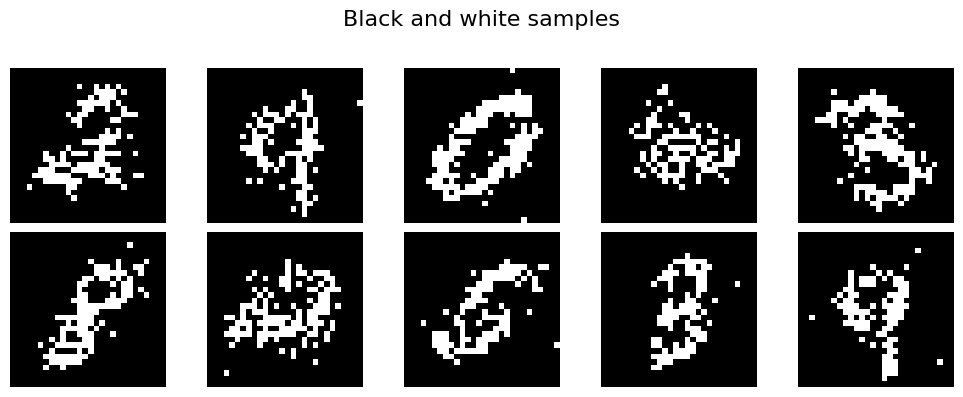

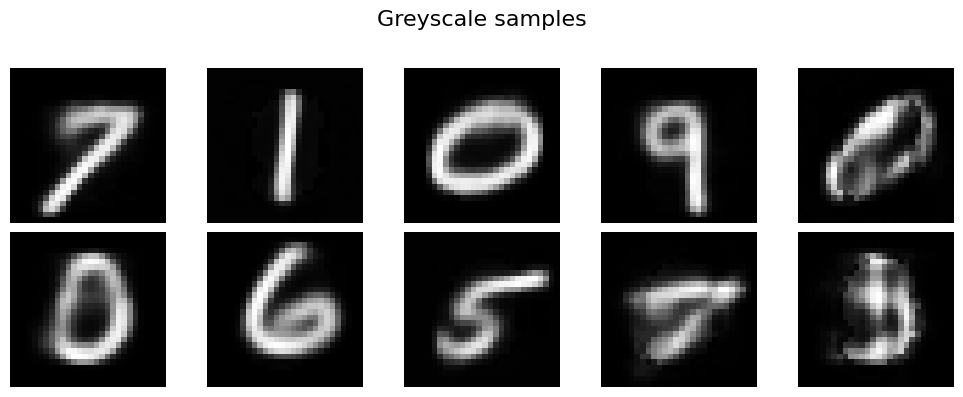

In [21]:
sample_images(my_model)

## train over fashionMNIST

In [13]:
train_loader = train_loader_FashionMNIST
val_loader = val_loader_FashionMNIST
input_dim = 784

### latent_dim = 12


In [14]:
#### features = 12, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/FashionMNIST/ld12_glog2_ep7_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=12, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/FashionMNIST/ld12_glog2_ep7_lmb01_dr05_gKLlog2_LN_1hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 390.5580
Epoch: 1/15, Average loss: 328.8307
Epoch: 2/15, Average loss: 301.4959
Epoch: 3/15, Average loss: 282.8894
Epoch: 4/15, Average loss: 270.0157
Epoch: 5/15, Average loss: 261.8850
Epoch: 6/15, Average loss: 256.6333
Epoch: 7/15, Average loss: 252.8290
Epoch: 8/15, Average loss: 250.1731
Epoch: 9/15, Average loss: 248.1693
Epoch: 10/15, Average loss: 246.2765
Epoch: 11/15, Average loss: 244.8467
Epoch: 12/15, Average loss: 243.6671
Epoch: 13/15, Average loss: 242.5018
Epoch: 14/15, Average loss: 241.4765
Training completato e dati scritti su tensorboard
Parameters saved


In [15]:

#### features = 12, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/FashionMNIST/ld12_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=12, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/FashionMNIST/ld12_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 390.7023
Epoch: 1/15, Average loss: 329.8947
Epoch: 2/15, Average loss: 301.9531
Epoch: 3/15, Average loss: 283.2363
Epoch: 4/15, Average loss: 270.1758
Epoch: 5/15, Average loss: 261.6072
Epoch: 6/15, Average loss: 256.2617
Epoch: 7/15, Average loss: 252.4125
Epoch: 8/15, Average loss: 249.4742
Epoch: 9/15, Average loss: 247.0539
Epoch: 10/15, Average loss: 245.2985
Epoch: 11/15, Average loss: 243.9185
Epoch: 12/15, Average loss: 242.5683
Epoch: 13/15, Average loss: 241.5314
Epoch: 14/15, Average loss: 240.5676
Training completato e dati scritti su tensorboard
Parameters saved


In [16]:

#### features = 12, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_HFM/FashionMNIST/ld12_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=12, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/FashionMNIST/ld12_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 392.7611
Epoch: 1/15, Average loss: 332.3344
Epoch: 2/15, Average loss: 304.8491
Epoch: 3/15, Average loss: 285.1961
Epoch: 4/15, Average loss: 272.0609
Epoch: 5/15, Average loss: 263.5342
Epoch: 6/15, Average loss: 257.9186
Epoch: 7/15, Average loss: 253.8324
Epoch: 8/15, Average loss: 250.7719
Epoch: 9/15, Average loss: 248.5465
Epoch: 10/15, Average loss: 246.4548
Epoch: 11/15, Average loss: 244.7143
Epoch: 12/15, Average loss: 243.6010
Epoch: 13/15, Average loss: 242.4122
Epoch: 14/15, Average loss: 241.4052
Training completato e dati scritti su tensorboard
Parameters saved


In [17]:

#### features = 12, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_HFM/FashionMNIST/ld12_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=12, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/FashionMNIST/ld12_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 396.8559
Epoch: 1/15, Average loss: 334.7537
Epoch: 2/15, Average loss: 309.1033
Epoch: 3/15, Average loss: 288.9122
Epoch: 4/15, Average loss: 274.7021
Epoch: 5/15, Average loss: 265.8321
Epoch: 6/15, Average loss: 259.9738
Epoch: 7/15, Average loss: 256.1328
Epoch: 8/15, Average loss: 252.9517
Epoch: 9/15, Average loss: 250.8496
Epoch: 10/15, Average loss: 249.0158
Epoch: 11/15, Average loss: 247.4768
Epoch: 12/15, Average loss: 246.1288
Epoch: 13/15, Average loss: 245.3457
Epoch: 14/15, Average loss: 244.0072
Training completato e dati scritti su tensorboard
Parameters saved


In [18]:

#### features = 12, g_model = log(2), epochs = 15, decrease_rate = 0.55, g_HFM per KL = log2, hidden layers = 5

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_HFM/FashionMNIST/ld12_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=12, g=np.log(2), decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/FashionMNIST/ld12_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 407.5538
Epoch: 1/15, Average loss: 340.1971
Epoch: 2/15, Average loss: 314.3715
Epoch: 3/15, Average loss: 298.1911
Epoch: 4/15, Average loss: 284.1517
Epoch: 5/15, Average loss: 272.4562
Epoch: 6/15, Average loss: 265.0021
Epoch: 7/15, Average loss: 259.9460
Epoch: 8/15, Average loss: 256.7584
Epoch: 9/15, Average loss: 253.5896
Epoch: 10/15, Average loss: 251.3511
Epoch: 11/15, Average loss: 249.8446
Epoch: 12/15, Average loss: 248.3605
Epoch: 13/15, Average loss: 247.4314
Epoch: 14/15, Average loss: 246.2766
Training completato e dati scritti su tensorboard
Parameters saved


In [19]:

#### features = 12, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_HFM/FashionMNIST/ld12_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=12, g=np.log(2), decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/FashionMNIST/ld12_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 403.7192
Epoch: 1/15, Average loss: 344.3157
Epoch: 2/15, Average loss: 318.1620
Epoch: 3/15, Average loss: 302.7861
Epoch: 4/15, Average loss: 290.4061
Epoch: 5/15, Average loss: 278.3420
Epoch: 6/15, Average loss: 270.3972
Epoch: 7/15, Average loss: 265.0974
Epoch: 8/15, Average loss: 261.1610
Epoch: 9/15, Average loss: 258.2593
Epoch: 10/15, Average loss: 256.0371
Epoch: 11/15, Average loss: 253.8625
Epoch: 12/15, Average loss: 252.1910
Epoch: 13/15, Average loss: 251.3083
Epoch: 14/15, Average loss: 249.6799
Training completato e dati scritti su tensorboard
Parameters saved



### latent_dim = 8



#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1


In [25]:

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/FashionMNIST/ld8_glog2_ep7_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/FashionMNIST/ld8_glog2_ep7_lmb01_dr05_gKLlog2_LN_1hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 393.8527
Epoch: 1/15, Average loss: 333.0312
Epoch: 2/15, Average loss: 307.6510
Epoch: 3/15, Average loss: 290.6462
Epoch: 4/15, Average loss: 277.5916
Epoch: 5/15, Average loss: 268.8914
Epoch: 6/15, Average loss: 263.5379
Epoch: 7/15, Average loss: 259.7359
Epoch: 8/15, Average loss: 256.8149
Epoch: 9/15, Average loss: 254.4613
Epoch: 10/15, Average loss: 252.5904
Epoch: 11/15, Average loss: 250.8536
Epoch: 12/15, Average loss: 249.6486
Epoch: 13/15, Average loss: 248.5295
Epoch: 14/15, Average loss: 247.4250
Training completato e dati scritti su tensorboard
Parameters saved




#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2



In [ ]:


writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/FashionMNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/FashionMNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth')
print('Parameters saved')

Epoch: 0/15, Average loss: 394.6638
Epoch: 1/15, Average loss: 333.7562
Epoch: 2/15, Average loss: 307.5900
Epoch: 3/15, Average loss: 289.5058
Epoch: 4/15, Average loss: 276.9208
Epoch: 5/15, Average loss: 268.5197
Epoch: 6/15, Average loss: 262.9799
Epoch: 7/15, Average loss: 259.2604
Epoch: 8/15, Average loss: 256.2368
Epoch: 9/15, Average loss: 253.8237
Epoch: 10/15, Average loss: 251.8655
Epoch: 11/15, Average loss: 250.1550
Epoch: 12/15, Average loss: 248.6765
Epoch: 13/15, Average loss: 247.2953
Epoch: 14/15, Average loss: 246.0844
Training completato e dati scritti su tensorboard
Parameters saved



#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3



In [27]:


writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/FashionMNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/FashionMNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 397.8299
Epoch: 1/15, Average loss: 335.6916
Epoch: 2/15, Average loss: 310.4764
Epoch: 3/15, Average loss: 292.3859
Epoch: 4/15, Average loss: 278.5663
Epoch: 5/15, Average loss: 269.3754
Epoch: 6/15, Average loss: 263.2122
Epoch: 7/15, Average loss: 258.7293
Epoch: 8/15, Average loss: 255.4832
Epoch: 9/15, Average loss: 253.1279
Epoch: 10/15, Average loss: 250.9017
Epoch: 11/15, Average loss: 249.3471
Epoch: 12/15, Average loss: 247.9899
Epoch: 13/15, Average loss: 246.8600
Epoch: 14/15, Average loss: 245.4575
Training completato e dati scritti su tensorboard
Parameters saved




#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4



In [28]:


writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/FashionMNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/FashionMNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')

Epoch: 0/15, Average loss: 398.3482
Epoch: 1/15, Average loss: 336.9857
Epoch: 2/15, Average loss: 312.6492
Epoch: 3/15, Average loss: 295.5657
Epoch: 4/15, Average loss: 281.1785
Epoch: 5/15, Average loss: 271.4434
Epoch: 6/15, Average loss: 265.2860
Epoch: 7/15, Average loss: 261.1684
Epoch: 8/15, Average loss: 258.2306
Epoch: 9/15, Average loss: 256.0380
Epoch: 10/15, Average loss: 253.8234
Epoch: 11/15, Average loss: 252.1474
Epoch: 12/15, Average loss: 250.8369
Epoch: 13/15, Average loss: 249.6603
Epoch: 14/15, Average loss: 248.8128
Training completato e dati scritti su tensorboard
Parameters saved


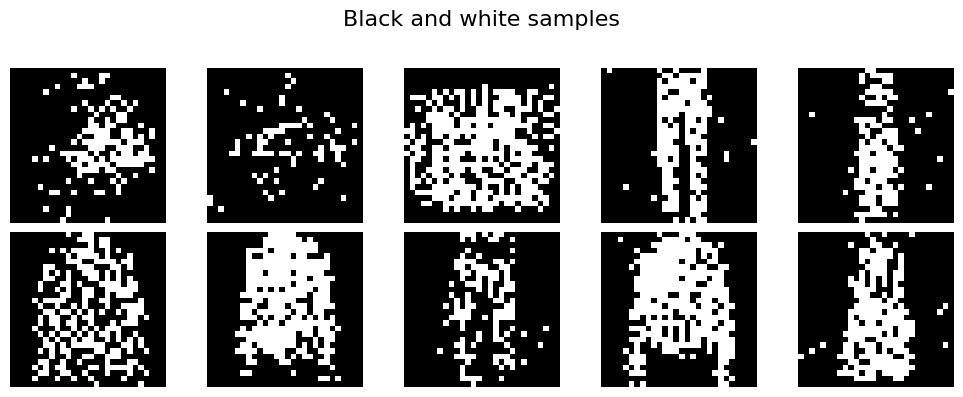

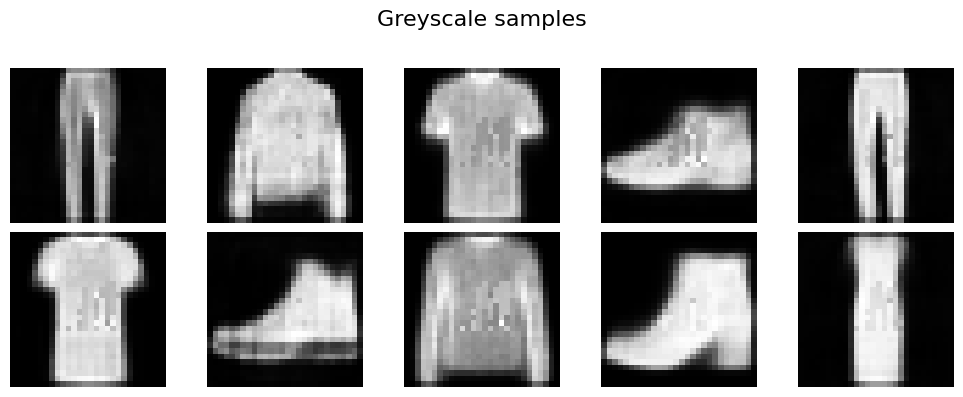

In [35]:
sample_images(my_model)




#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.55, g_HFM per KL = log2, hidden layers = 5



In [38]:


writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/FashionMNIST/ld8_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/FashionMNIST/ld8_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth')
print('Parameters saved')



Epoch: 0/15, Average loss: 400.3358
Epoch: 1/15, Average loss: 340.4148
Epoch: 2/15, Average loss: 317.3384
Epoch: 3/15, Average loss: 302.8063
Epoch: 4/15, Average loss: 290.0570
Epoch: 5/15, Average loss: 277.6104
Epoch: 6/15, Average loss: 269.5549
Epoch: 7/15, Average loss: 264.5253
Epoch: 8/15, Average loss: 260.6654
Epoch: 9/15, Average loss: 258.6063
Epoch: 10/15, Average loss: 256.3294
Epoch: 11/15, Average loss: 254.8966
Epoch: 12/15, Average loss: 253.4899
Epoch: 13/15, Average loss: 252.2174
Epoch: 14/15, Average loss: 251.0709
Training completato e dati scritti su tensorboard
Parameters saved




#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6


In [37]:


writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/FashionMNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/FashionMNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth')
print('Parameters saved')

Epoch: 0/15, Average loss: 402.9198
Epoch: 1/15, Average loss: 345.1993
Epoch: 2/15, Average loss: 321.5186
Epoch: 3/15, Average loss: 306.7467
Epoch: 4/15, Average loss: 296.3839
Epoch: 5/15, Average loss: 283.5194
Epoch: 6/15, Average loss: 274.3747
Epoch: 7/15, Average loss: 267.8208
Epoch: 8/15, Average loss: 263.7321
Epoch: 9/15, Average loss: 260.8180
Epoch: 10/15, Average loss: 258.8114
Epoch: 11/15, Average loss: 256.8465
Epoch: 12/15, Average loss: 254.9873
Epoch: 13/15, Average loss: 254.0814
Epoch: 14/15, Average loss: 252.5321
Training completato e dati scritti su tensorboard
Parameters saved


### latent_dim = 20

#### features = 20, g_model = log(2), epochs = 20, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1

In [ ]:
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/FashionMNIST/ld20_glog2_ep20_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=20, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=20, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/FashionMNIST/ld20_glog2_ep20_lmb01_dr05_gKLlog2_LN_1hl_0.pth')
print('Parameters saved')


#### features = 20, g_model = log(2), epochs = 20, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2


In [22]:
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/FashionMNIST/ld20_glog2_ep20_lmb01_dr05_gKLlog2_NL_2hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=20, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=20, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/FashionMNIST/ld20_glog2_ep20_lmb01_dr05_gKLlog2_NL_2hl_0.pth')
print('Parameters saved')


Epoch: 0/20, Average loss: 389.0890
Epoch: 1/20, Average loss: 325.6962
Epoch: 2/20, Average loss: 296.0037
Epoch: 3/20, Average loss: 276.8709
Epoch: 4/20, Average loss: 264.3897
Epoch: 5/20, Average loss: 256.0267
Epoch: 6/20, Average loss: 250.3627
Epoch: 7/20, Average loss: 246.3227
Epoch: 8/20, Average loss: 243.3773
Epoch: 9/20, Average loss: 240.8766
Epoch: 10/20, Average loss: 239.0853
Epoch: 11/20, Average loss: 237.3914
Epoch: 12/20, Average loss: 236.1984
Epoch: 13/20, Average loss: 235.3642
Epoch: 14/20, Average loss: 234.4350
Epoch: 15/20, Average loss: 233.6106
Epoch: 16/20, Average loss: 232.8913
Epoch: 17/20, Average loss: 232.4347
Epoch: 18/20, Average loss: 232.0001
Epoch: 19/20, Average loss: 231.4370
Training completato e dati scritti su tensorboard
Parameters saved


#### features = 20, g_model = log(2), epochs = 20, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3


In [21]:
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/FashionMNIST/ld20_glog2_ep20_lmb01_dr05_gKLlog2_NL_3hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=20, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=20, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/FashionMNIST/ld20_glog2_ep20_lmb01_dr05_gKLlog2_NL_3hl_0.pth')
print('Parameters saved')


Epoch: 0/20, Average loss: 392.7184
Epoch: 1/20, Average loss: 330.1752
Epoch: 2/20, Average loss: 300.8050
Epoch: 3/20, Average loss: 281.0163
Epoch: 4/20, Average loss: 267.9777
Epoch: 5/20, Average loss: 259.1248
Epoch: 6/20, Average loss: 252.9723
Epoch: 7/20, Average loss: 248.8830
Epoch: 8/20, Average loss: 245.6547
Epoch: 9/20, Average loss: 243.3275
Epoch: 10/20, Average loss: 241.1693
Epoch: 11/20, Average loss: 239.6135
Epoch: 12/20, Average loss: 238.4788
Epoch: 13/20, Average loss: 237.2878
Epoch: 14/20, Average loss: 235.9741
Epoch: 15/20, Average loss: 235.5782
Epoch: 16/20, Average loss: 234.4863
Epoch: 17/20, Average loss: 234.0487
Epoch: 18/20, Average loss: 233.5277
Epoch: 19/20, Average loss: 232.8822
Training completato e dati scritti su tensorboard
Parameters saved


#### features = 20, g_model = log(2), epochs = 20, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4


In [20]:
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/FashionMNIST/ld20_glog2_ep20_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=20, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=20, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/FashionMNIST/ld20_glog2_ep20_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')


Epoch: 0/20, Average loss: 392.8488
Epoch: 1/20, Average loss: 331.2440
Epoch: 2/20, Average loss: 303.7108
Epoch: 3/20, Average loss: 283.6276
Epoch: 4/20, Average loss: 270.1510
Epoch: 5/20, Average loss: 261.5015
Epoch: 6/20, Average loss: 255.8282
Epoch: 7/20, Average loss: 251.6353
Epoch: 8/20, Average loss: 248.6680
Epoch: 9/20, Average loss: 246.2480
Epoch: 10/20, Average loss: 244.4681
Epoch: 11/20, Average loss: 242.5636
Epoch: 12/20, Average loss: 241.5544
Epoch: 13/20, Average loss: 240.5480
Epoch: 14/20, Average loss: 239.3995
Epoch: 15/20, Average loss: 238.5651
Epoch: 16/20, Average loss: 237.6737
Epoch: 17/20, Average loss: 237.2265
Epoch: 18/20, Average loss: 236.5799
Epoch: 19/20, Average loss: 235.9901
Training completato e dati scritti su tensorboard
Parameters saved


#### features = 20, g_model = log(2), epochs = 20, hidden layers = 5, decrease_rate = 0.55, g_HFM per KL = log2


In [19]:
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/FashionMNIST/ld20_glog2_ep20_lmb01_dr055_gKLlog2_NL_5hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=20, g=np.log(2), decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=20, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/FashionMNIST/ld20_glog2_ep20_lmb01_dr055_gKLlog2_NL_5hl_0.pth')
print('Parameters saved')


Epoch: 0/20, Average loss: 397.4748
Epoch: 1/20, Average loss: 333.8013
Epoch: 2/20, Average loss: 308.7578
Epoch: 3/20, Average loss: 288.8149
Epoch: 4/20, Average loss: 274.2027
Epoch: 5/20, Average loss: 265.1079
Epoch: 6/20, Average loss: 259.0098
Epoch: 7/20, Average loss: 254.6710
Epoch: 8/20, Average loss: 251.5748
Epoch: 9/20, Average loss: 249.3519
Epoch: 10/20, Average loss: 247.4829
Epoch: 11/20, Average loss: 245.3746
Epoch: 12/20, Average loss: 244.7032
Epoch: 13/20, Average loss: 242.9167
Epoch: 14/20, Average loss: 241.8273
Epoch: 15/20, Average loss: 241.1356
Epoch: 16/20, Average loss: 240.2478
Epoch: 17/20, Average loss: 239.6516
Epoch: 18/20, Average loss: 238.8100
Epoch: 19/20, Average loss: 239.0816
Training completato e dati scritti su tensorboard
Parameters saved


#### features = 20, g_model = log(2), epochs = 20, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6

In [ ]:
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/FashionMNIST/ld20_glog2_ep20_lmb01_dr06_gKLlog2_NL_6hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=20, g=np.log(2), decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=20, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/FashionMNIST/ld20_glog2_ep20_lmb01_dr06_gKLlog2_NL_6hl_0.pth')
print('Parameters saved')




## train over pureHFM

In [5]:
train_loader = train_loader_pureHFM
val_loader = val_loader_pureHFM
input_dim = 512

### latent_dim = 8


#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1


In [ ]:

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/pureHFM/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/pureHFM/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth')
print('Parameters saved')
    


Epoch: 0/15, Average loss: 284.7243
Epoch: 1/15, Average loss: 236.6423
Epoch: 2/15, Average loss: 218.7505
Epoch: 3/15, Average loss: 208.8073
Epoch: 4/15, Average loss: 202.3695
Epoch: 5/15, Average loss: 197.5880
Epoch: 6/15, Average loss: 194.2041
Epoch: 7/15, Average loss: 191.8665
Epoch: 8/15, Average loss: 190.1675
Epoch: 9/15, Average loss: 188.8633
Epoch: 10/15, Average loss: 187.8459
Epoch: 11/15, Average loss: 187.0252
Epoch: 12/15, Average loss: 186.3370
Epoch: 13/15, Average loss: 185.7570
Epoch: 14/15, Average loss: 185.2364
Training completato e dati scritti su tensorboard
Parameters saved



#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2



In [22]:


writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/pureHFM/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/pureHFM/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 284.4261
Epoch: 1/15, Average loss: 236.2003
Epoch: 2/15, Average loss: 218.4437
Epoch: 3/15, Average loss: 208.6953
Epoch: 4/15, Average loss: 202.2707
Epoch: 5/15, Average loss: 197.5945
Epoch: 6/15, Average loss: 194.1586
Epoch: 7/15, Average loss: 191.8542
Epoch: 8/15, Average loss: 190.2589
Epoch: 9/15, Average loss: 188.9879
Epoch: 10/15, Average loss: 187.9349
Epoch: 11/15, Average loss: 187.0725
Epoch: 12/15, Average loss: 186.4054
Epoch: 13/15, Average loss: 185.8500
Epoch: 14/15, Average loss: 185.2787
Training completato e dati scritti su tensorboard
Parameters saved





#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3


In [23]:



writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/pureHFM/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/pureHFM/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 287.3755
Epoch: 1/15, Average loss: 237.0502
Epoch: 2/15, Average loss: 219.5545
Epoch: 3/15, Average loss: 209.5671
Epoch: 4/15, Average loss: 202.7791
Epoch: 5/15, Average loss: 197.9154
Epoch: 6/15, Average loss: 194.5951
Epoch: 7/15, Average loss: 192.2125
Epoch: 8/15, Average loss: 190.5190
Epoch: 9/15, Average loss: 189.2600
Epoch: 10/15, Average loss: 188.1938
Epoch: 11/15, Average loss: 187.2816
Epoch: 12/15, Average loss: 186.8389
Epoch: 13/15, Average loss: 186.0661
Epoch: 14/15, Average loss: 185.5707
Training completato e dati scritti su tensorboard
Parameters saved





#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4


In [24]:



writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/pureHFM/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/pureHFM/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 284.7288
Epoch: 1/15, Average loss: 236.6928
Epoch: 2/15, Average loss: 219.0489
Epoch: 3/15, Average loss: 209.1980
Epoch: 4/15, Average loss: 202.8524
Epoch: 5/15, Average loss: 198.0753
Epoch: 6/15, Average loss: 194.6767
Epoch: 7/15, Average loss: 192.2970
Epoch: 8/15, Average loss: 190.5979
Epoch: 9/15, Average loss: 189.3843
Epoch: 10/15, Average loss: 188.2781
Epoch: 11/15, Average loss: 187.4554
Epoch: 12/15, Average loss: 186.7519
Epoch: 13/15, Average loss: 186.1111
Epoch: 14/15, Average loss: 185.6430
Training completato e dati scritti su tensorboard
Parameters saved





#### features = 8, g_model = log(2), epochs = 15, hidden layers = 5, decrease_rate = 0.55, g_HFM per KL = log2



In [25]:


writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/pureHFM/ld8_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/pureHFM/ld8_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth')
print('Parameters saved')



Epoch: 0/15, Average loss: 287.7852
Epoch: 1/15, Average loss: 237.5617
Epoch: 2/15, Average loss: 220.1914
Epoch: 3/15, Average loss: 210.3694
Epoch: 4/15, Average loss: 203.5353
Epoch: 5/15, Average loss: 198.6652
Epoch: 6/15, Average loss: 195.2864
Epoch: 7/15, Average loss: 193.0813
Epoch: 8/15, Average loss: 191.3384
Epoch: 9/15, Average loss: 189.9766
Epoch: 10/15, Average loss: 188.9391
Epoch: 11/15, Average loss: 188.0414
Epoch: 12/15, Average loss: 187.3425
Epoch: 13/15, Average loss: 186.8371
Epoch: 14/15, Average loss: 186.1999
Training completato e dati scritti su tensorboard
Parameters saved




#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6


In [26]:

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/pureHFM/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/pureHFM/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth')
print('Parameters saved')

Epoch: 0/15, Average loss: 292.6029
Epoch: 1/15, Average loss: 238.5189
Epoch: 2/15, Average loss: 220.9748
Epoch: 3/15, Average loss: 210.9588
Epoch: 4/15, Average loss: 204.0923
Epoch: 5/15, Average loss: 199.1431
Epoch: 6/15, Average loss: 195.4405
Epoch: 7/15, Average loss: 192.9559
Epoch: 8/15, Average loss: 191.2045
Epoch: 9/15, Average loss: 189.9498
Epoch: 10/15, Average loss: 189.1115
Epoch: 11/15, Average loss: 187.8321
Epoch: 12/15, Average loss: 187.3549
Epoch: 13/15, Average loss: 186.6793
Epoch: 14/15, Average loss: 186.0641
Training completato e dati scritti su tensorboard
Parameters saved


### latent_dim = 10


In [ ]:

#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1


writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/pureHFM/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/pureHFM/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 284.8464
Epoch: 1/15, Average loss: 236.1935
Epoch: 2/15, Average loss: 218.5763
Epoch: 3/15, Average loss: 208.8317
Epoch: 4/15, Average loss: 202.2423
Epoch: 5/15, Average loss: 197.4519
Epoch: 6/15, Average loss: 194.0614
Epoch: 7/15, Average loss: 191.6466
Epoch: 8/15, Average loss: 189.8962
Epoch: 9/15, Average loss: 188.5487
Epoch: 10/15, Average loss: 187.4814
Epoch: 11/15, Average loss: 186.5976
Epoch: 12/15, Average loss: 185.8504
Epoch: 13/15, Average loss: 185.2475
Epoch: 14/15, Average loss: 184.7187
Training completato e dati scritti su tensorboard
Parameters saved


In [ ]:
#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/pureHFM/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_2hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/pureHFM/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_2hl_0.pth')
print('Parameters saved')



Epoch: 0/15, Average loss: 283.7363
Epoch: 1/15, Average loss: 235.5655
Epoch: 2/15, Average loss: 217.9087
Epoch: 3/15, Average loss: 208.3028
Epoch: 4/15, Average loss: 201.9814
Epoch: 5/15, Average loss: 197.2498
Epoch: 6/15, Average loss: 193.8478
Epoch: 7/15, Average loss: 191.4785
Epoch: 8/15, Average loss: 189.7849
Epoch: 9/15, Average loss: 188.5196
Epoch: 10/15, Average loss: 187.5343
Epoch: 11/15, Average loss: 186.6833
Epoch: 12/15, Average loss: 185.9613
Epoch: 13/15, Average loss: 185.3660
Epoch: 14/15, Average loss: 184.8252
Training completato e dati scritti su tensorboard
Parameters saved


In [ ]:
#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/pureHFM/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_3hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/pureHFM/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_3hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 285.2223
Epoch: 1/15, Average loss: 236.3018
Epoch: 2/15, Average loss: 218.7822
Epoch: 3/15, Average loss: 208.9726
Epoch: 4/15, Average loss: 202.4610
Epoch: 5/15, Average loss: 197.6650
Epoch: 6/15, Average loss: 194.2955
Epoch: 7/15, Average loss: 192.0910
Epoch: 8/15, Average loss: 190.4163
Epoch: 9/15, Average loss: 189.1646
Epoch: 10/15, Average loss: 188.1475
Epoch: 11/15, Average loss: 187.3214
Epoch: 12/15, Average loss: 186.5558
Epoch: 13/15, Average loss: 185.9756
Epoch: 14/15, Average loss: 185.5028
Training completato e dati scritti su tensorboard
Parameters saved


In [30]:
#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/pureHFM/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/pureHFM/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')



Epoch: 0/15, Average loss: 287.0142
Epoch: 1/15, Average loss: 236.6771
Epoch: 2/15, Average loss: 219.3834
Epoch: 3/15, Average loss: 209.4740
Epoch: 4/15, Average loss: 202.7421
Epoch: 5/15, Average loss: 197.9045
Epoch: 6/15, Average loss: 194.7804
Epoch: 7/15, Average loss: 192.4768
Epoch: 8/15, Average loss: 190.7469
Epoch: 9/15, Average loss: 189.4877
Epoch: 10/15, Average loss: 188.5356
Epoch: 11/15, Average loss: 187.6153
Epoch: 12/15, Average loss: 186.8701
Epoch: 13/15, Average loss: 186.3621
Epoch: 14/15, Average loss: 185.8067
Training completato e dati scritti su tensorboard
Parameters saved


In [ ]:
#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.55, g_HFM per KL = log2, hidden layers = 5

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/pureHFM/ld10_glog2_ep15_lmb01_dr055_gKLlog2_LN_5hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/pureHFM/ld10_glog2_ep15_lmb01_dr055_gKLlog2_LN_5hl_0.pth')
print('Parameters saved')



Epoch: 0/15, Average loss: 292.8941
Epoch: 1/15, Average loss: 237.9449
Epoch: 2/15, Average loss: 220.1433
Epoch: 3/15, Average loss: 210.1393
Epoch: 4/15, Average loss: 203.2156
Epoch: 5/15, Average loss: 198.3725
Epoch: 6/15, Average loss: 194.8614
Epoch: 7/15, Average loss: 192.6915
Epoch: 8/15, Average loss: 190.9345
Epoch: 9/15, Average loss: 189.7620
Epoch: 10/15, Average loss: 188.5940
Epoch: 11/15, Average loss: 187.7056
Epoch: 12/15, Average loss: 186.9935
Epoch: 13/15, Average loss: 186.8883
Epoch: 14/15, Average loss: 186.0274
Training completato e dati scritti su tensorboard
Parameters saved


In [ ]:
#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6


writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/pureHFM/ld10_glog2_ep15_lmb01_dr06_gKLlog2_LN_6hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/pureHFM/ld10_glog2_ep15_lmb01_dr06_gKLlog2_LN_6hl_0.pth')
print('Parameters saved')

Epoch: 0/15, Average loss: 290.9737
Epoch: 1/15, Average loss: 238.1177
Epoch: 2/15, Average loss: 220.4897
Epoch: 3/15, Average loss: 210.6305
Epoch: 4/15, Average loss: 203.6614
Epoch: 5/15, Average loss: 198.8301
Epoch: 6/15, Average loss: 195.4852
Epoch: 7/15, Average loss: 193.0148
Epoch: 8/15, Average loss: 191.4951
Epoch: 9/15, Average loss: 189.9841
Epoch: 10/15, Average loss: 188.9502
Epoch: 11/15, Average loss: 188.2171
Epoch: 12/15, Average loss: 187.2930
Epoch: 13/15, Average loss: 186.7010
Epoch: 14/15, Average loss: 186.2205
Training completato e dati scritti su tensorboard
Parameters saved


### latent_dim = 12


In [ ]:
#### features = 12, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_HFM/pureHFM/ld12_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=12, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/pureHFM/ld12_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 284.5432
Epoch: 1/15, Average loss: 236.0743
Epoch: 1/15, Average loss: 236.0743
Epoch: 2/15, Average loss: 218.6306
Epoch: 2/15, Average loss: 218.6306
Epoch: 3/15, Average loss: 208.9190
Epoch: 3/15, Average loss: 208.9190
Epoch: 4/15, Average loss: 202.0166
Epoch: 4/15, Average loss: 202.0166
Epoch: 5/15, Average loss: 197.0756
Epoch: 5/15, Average loss: 197.0756
Epoch: 6/15, Average loss: 193.6763
Epoch: 6/15, Average loss: 193.6763
Epoch: 7/15, Average loss: 191.3216
Epoch: 7/15, Average loss: 191.3216
Epoch: 8/15, Average loss: 189.5958
Epoch: 8/15, Average loss: 189.5958
Epoch: 9/15, Average loss: 188.2371
Epoch: 9/15, Average loss: 188.2371
Epoch: 10/15, Average loss: 187.1204
Epoch: 10/15, Average loss: 187.1204
Epoch: 11/15, Average loss: 186.2441
Epoch: 11/15, Average loss: 186.2441
Epoch: 12/15, Average loss: 185.4375
Epoch: 12/15, Average loss: 185.4375
Epoch: 13/15, Average loss: 184.8307
Epoch: 13/15, Average loss: 184.8307
Epoch: 14/15, Averag

In [ ]:
#### features = 12, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_HFM/pureHFM/ld12_glog2_ep15_lmb01_dr05_gKLlog2_LN_2hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=12, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/pureHFM/ld12_glog2_ep15_lmb01_dr05_gKLlog2_LN_2hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 284.1642
Epoch: 1/15, Average loss: 235.6598
Epoch: 1/15, Average loss: 235.6598
Epoch: 2/15, Average loss: 217.7534
Epoch: 2/15, Average loss: 217.7534
Epoch: 3/15, Average loss: 208.2301
Epoch: 3/15, Average loss: 208.2301
Epoch: 4/15, Average loss: 202.0851
Epoch: 4/15, Average loss: 202.0851
Epoch: 5/15, Average loss: 197.3137
Epoch: 5/15, Average loss: 197.3137
Epoch: 6/15, Average loss: 193.7529
Epoch: 6/15, Average loss: 193.7529
Epoch: 7/15, Average loss: 191.3909
Epoch: 7/15, Average loss: 191.3909
Epoch: 8/15, Average loss: 189.6400
Epoch: 8/15, Average loss: 189.6400
Epoch: 9/15, Average loss: 188.3069
Epoch: 9/15, Average loss: 188.3069
Epoch: 10/15, Average loss: 187.2378
Epoch: 10/15, Average loss: 187.2378
Epoch: 11/15, Average loss: 186.3681
Epoch: 11/15, Average loss: 186.3681
Epoch: 12/15, Average loss: 185.7713
Epoch: 12/15, Average loss: 185.7713
Epoch: 13/15, Average loss: 185.1249
Epoch: 13/15, Average loss: 185.1249
Epoch: 14/15, Averag

In [7]:
#### features = 12, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/pureHFM/ld12_glog2_ep15_lmb01_dr05_gKLlog2_LN_3hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=12, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/pureHFM/ld12_glog2_ep15_lmb01_dr05_gKLlog2_LN_3hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 284.3945
Epoch: 1/15, Average loss: 236.0290
Epoch: 1/15, Average loss: 236.0290
Epoch: 2/15, Average loss: 218.3815
Epoch: 2/15, Average loss: 218.3815
Epoch: 3/15, Average loss: 208.5937
Epoch: 3/15, Average loss: 208.5937
Epoch: 4/15, Average loss: 202.1195
Epoch: 4/15, Average loss: 202.1195
Epoch: 5/15, Average loss: 197.3906
Epoch: 5/15, Average loss: 197.3906
Epoch: 6/15, Average loss: 194.0364
Epoch: 6/15, Average loss: 194.0364
Epoch: 7/15, Average loss: 191.7625
Epoch: 7/15, Average loss: 191.7625
Epoch: 8/15, Average loss: 190.0751
Epoch: 8/15, Average loss: 190.0751
Epoch: 9/15, Average loss: 188.7873
Epoch: 9/15, Average loss: 188.7873
Epoch: 10/15, Average loss: 187.8294
Epoch: 10/15, Average loss: 187.8294
Epoch: 11/15, Average loss: 186.9817
Epoch: 11/15, Average loss: 186.9817
Epoch: 12/15, Average loss: 186.2350
Epoch: 12/15, Average loss: 186.2350
Epoch: 13/15, Average loss: 185.6789
Epoch: 13/15, Average loss: 185.6789
Epoch: 14/15, Averag

In [9]:
#### features = 12, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/pureHFM/ld12_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=12, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/pureHFM/ld12_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 284.3178
Epoch: 1/15, Average loss: 236.2829
Epoch: 1/15, Average loss: 236.2829
Epoch: 2/15, Average loss: 218.3552
Epoch: 2/15, Average loss: 218.3552
Epoch: 3/15, Average loss: 208.6827
Epoch: 3/15, Average loss: 208.6827
Epoch: 4/15, Average loss: 202.2258
Epoch: 4/15, Average loss: 202.2258
Epoch: 5/15, Average loss: 197.5253
Epoch: 5/15, Average loss: 197.5253
Epoch: 6/15, Average loss: 194.2341
Epoch: 6/15, Average loss: 194.2341
Epoch: 7/15, Average loss: 191.9013
Epoch: 7/15, Average loss: 191.9013
Epoch: 8/15, Average loss: 190.1920
Epoch: 8/15, Average loss: 190.1920
Epoch: 9/15, Average loss: 188.9356
Epoch: 9/15, Average loss: 188.9356
Epoch: 10/15, Average loss: 188.1370
Epoch: 10/15, Average loss: 188.1370
Epoch: 11/15, Average loss: 187.1928
Epoch: 11/15, Average loss: 187.1928
Epoch: 12/15, Average loss: 186.4941
Epoch: 12/15, Average loss: 186.4941
Epoch: 13/15, Average loss: 185.9425
Epoch: 13/15, Average loss: 185.9425
Epoch: 14/15, Averag

In [10]:
#### features = 12, g_model = log(2), epochs = 15, decrease_rate = 0.55, g_HFM per KL = log2, hidden layers = 5

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/pureHFM/ld12_glog2_ep15_lmb01_dr055_gKLlog2_LN_5hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=12, g=np.log(2), decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/pureHFM/ld12_glog2_ep15_lmb01_dr055_gKLlog2_LN_5hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 289.7564
Epoch: 1/15, Average loss: 237.0259
Epoch: 1/15, Average loss: 237.0259
Epoch: 2/15, Average loss: 219.7418
Epoch: 2/15, Average loss: 219.7418
Epoch: 3/15, Average loss: 210.0837
Epoch: 3/15, Average loss: 210.0837
Epoch: 4/15, Average loss: 202.9634
Epoch: 4/15, Average loss: 202.9634
Epoch: 5/15, Average loss: 198.2069
Epoch: 5/15, Average loss: 198.2069
Epoch: 6/15, Average loss: 194.9044
Epoch: 6/15, Average loss: 194.9044
Epoch: 7/15, Average loss: 192.4980
Epoch: 7/15, Average loss: 192.4980
Epoch: 8/15, Average loss: 190.9749
Epoch: 8/15, Average loss: 190.9749
Epoch: 9/15, Average loss: 189.7428
Epoch: 9/15, Average loss: 189.7428
Epoch: 10/15, Average loss: 188.6268
Epoch: 10/15, Average loss: 188.6268
Epoch: 11/15, Average loss: 187.7101
Epoch: 11/15, Average loss: 187.7101
Epoch: 12/15, Average loss: 187.0131
Epoch: 12/15, Average loss: 187.0131
Epoch: 13/15, Average loss: 186.5094
Epoch: 13/15, Average loss: 186.5094
Epoch: 14/15, Averag

In [11]:
#### features = 12, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/pureHFM/ld12_glog2_ep15_lmb01_dr06_gKLlog2_LN_6hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=12, g=np.log(2), decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/pureHFM/ld12_glog2_ep15_lmb01_dr06_gKLlog2_LN_6hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 286.2520
Epoch: 1/15, Average loss: 236.8761
Epoch: 1/15, Average loss: 236.8761
Epoch: 2/15, Average loss: 219.5001
Epoch: 2/15, Average loss: 219.5001
Epoch: 3/15, Average loss: 209.7490
Epoch: 3/15, Average loss: 209.7490
Epoch: 4/15, Average loss: 203.1729
Epoch: 4/15, Average loss: 203.1729
Epoch: 5/15, Average loss: 198.4472
Epoch: 5/15, Average loss: 198.4472
Epoch: 6/15, Average loss: 194.9621
Epoch: 6/15, Average loss: 194.9621
Epoch: 7/15, Average loss: 192.6821
Epoch: 7/15, Average loss: 192.6821
Epoch: 8/15, Average loss: 191.2539
Epoch: 8/15, Average loss: 191.2539
Epoch: 9/15, Average loss: 189.7987
Epoch: 9/15, Average loss: 189.7987
Epoch: 10/15, Average loss: 188.6366
Epoch: 10/15, Average loss: 188.6366
Epoch: 11/15, Average loss: 187.8787
Epoch: 11/15, Average loss: 187.8787
Epoch: 12/15, Average loss: 187.1668
Epoch: 12/15, Average loss: 187.1668
Epoch: 13/15, Average loss: 186.4914
Epoch: 13/15, Average loss: 186.4914
Epoch: 14/15, Averag

## train over expandedHFM 32-1024

In [7]:
train_loader = train_loader_expandedHFM_32_1024
val_loader = val_loader_expandedHFM_32_1024
input_dim = 1024

### latent_dim = 32

#### features = 32, g_model = log(2), epochs = 20, hidden layers = 1, decrease_rate = 0.5, g_HFM per KL = log2

In [28]:
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/expandedHFM_32_1024/ld32_glog2_ep20_lmb01_LN_dr05_gKLlog2_1hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=32, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=20, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/expandedHFM_32_1024/ld32_glog2_ep20_lmb01_LN_dr05_gKLlog2_1hl_0.pth')
print('Parameters saved')

Epoch: 0/20, Average loss: 369.4557
Epoch: 1/20, Average loss: 253.0922
Epoch: 2/20, Average loss: 202.8551
Epoch: 3/20, Average loss: 172.7191
Epoch: 4/20, Average loss: 152.2356
Epoch: 5/20, Average loss: 137.6990
Epoch: 6/20, Average loss: 126.6692
Epoch: 7/20, Average loss: 118.0560
Epoch: 8/20, Average loss: 111.1311
Epoch: 9/20, Average loss: 105.9597
Epoch: 10/20, Average loss: 101.8351
Epoch: 11/20, Average loss: 98.4729
Epoch: 12/20, Average loss: 95.4016
Epoch: 13/20, Average loss: 92.9106
Epoch: 14/20, Average loss: 90.9402
Epoch: 15/20, Average loss: 89.1270
Epoch: 16/20, Average loss: 87.6784
Epoch: 17/20, Average loss: 86.5530
Epoch: 18/20, Average loss: 85.3882
Epoch: 19/20, Average loss: 84.4254
Training completato e dati scritti su tensorboard
Parameters saved


#### features = 32, g_model = log(2), epochs = 20, hidden layers = 2, decrease_rate = 0.5, g_HFM per KL = log2

In [29]:
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/expandedHFM_32_1024/ld32_glog2_ep20_lmb01_LN_dr05_gKLlog2_2hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=32, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=20, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/expandedHFM_32_1024/ld32_glog2_ep20_lmb01_LN_dr05_gKLlog2_2hl_0.pth')
print('Parameters saved')

Epoch: 0/20, Average loss: 393.1789
Epoch: 1/20, Average loss: 300.7643
Epoch: 2/20, Average loss: 241.3813
Epoch: 3/20, Average loss: 207.7646
Epoch: 4/20, Average loss: 179.9620
Epoch: 5/20, Average loss: 160.1453
Epoch: 6/20, Average loss: 144.9132
Epoch: 7/20, Average loss: 133.3975
Epoch: 8/20, Average loss: 125.1795
Epoch: 9/20, Average loss: 118.3757
Epoch: 10/20, Average loss: 112.1573
Epoch: 11/20, Average loss: 107.3208
Epoch: 12/20, Average loss: 103.3839
Epoch: 13/20, Average loss: 99.9120
Epoch: 14/20, Average loss: 96.7396
Epoch: 15/20, Average loss: 94.4459
Epoch: 16/20, Average loss: 92.6706
Epoch: 17/20, Average loss: 90.7141
Epoch: 18/20, Average loss: 88.7004
Epoch: 19/20, Average loss: 87.0102
Training completato e dati scritti su tensorboard
Parameters saved


#### features = 32, g_model = log(2), epochs = 20, hidden layers = 3, decrease_rate = 0.5, g_HFM per KL = log2

In [30]:
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/expandedHFM_32_1024/ld32_glog2_ep20_lmb01_LN_dr05_gKLlog2_3hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=32, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=20, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/expandedHFM_32_1024/ld32_glog2_ep20_lmb01_LN_dr05_gKLlog2_3hl_0.pth')
print('Parameters saved')

Epoch: 0/20, Average loss: 399.2147
Epoch: 1/20, Average loss: 324.6712
Epoch: 2/20, Average loss: 275.4050
Epoch: 3/20, Average loss: 239.8818
Epoch: 4/20, Average loss: 216.3649
Epoch: 5/20, Average loss: 198.0273
Epoch: 6/20, Average loss: 182.2649
Epoch: 7/20, Average loss: 170.8574
Epoch: 8/20, Average loss: 162.9704
Epoch: 9/20, Average loss: 154.4810
Epoch: 10/20, Average loss: 146.7258
Epoch: 11/20, Average loss: 139.4719
Epoch: 12/20, Average loss: 134.2167
Epoch: 13/20, Average loss: 129.6427
Epoch: 14/20, Average loss: 125.4191
Epoch: 15/20, Average loss: 121.2396
Epoch: 16/20, Average loss: 118.2277
Epoch: 17/20, Average loss: 115.6689
Epoch: 18/20, Average loss: 112.8884
Epoch: 19/20, Average loss: 111.4160
Training completato e dati scritti su tensorboard
Parameters saved


#### features = 32, g_model = log(2), epochs = 20, hidden layers = 4, decrease_rate = 0.5, g_HFM per KL = log2

In [31]:
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/expandedHFM_32_1024/ld32_glog2_ep20_lmb01_LN_dr05_gKLlog2_4hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=32, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=20, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/expandedHFM_32_1024/ld32_glog2_ep20_lmb01_LN_dr05_gKLlog2_4hl_0.pth')
print('Parameters saved')

Epoch: 0/20, Average loss: 405.6318
Epoch: 1/20, Average loss: 331.2717
Epoch: 2/20, Average loss: 293.0868
Epoch: 3/20, Average loss: 260.4425
Epoch: 4/20, Average loss: 235.3888
Epoch: 5/20, Average loss: 217.5635
Epoch: 6/20, Average loss: 207.8059
Epoch: 7/20, Average loss: 200.4518
Epoch: 8/20, Average loss: 194.3792
Epoch: 9/20, Average loss: 189.3980
Epoch: 10/20, Average loss: 184.9584
Epoch: 11/20, Average loss: 179.7132
Epoch: 12/20, Average loss: 174.9633
Epoch: 13/20, Average loss: 170.7941
Epoch: 14/20, Average loss: 167.3850
Epoch: 15/20, Average loss: 164.2246
Epoch: 16/20, Average loss: 161.3431
Epoch: 17/20, Average loss: 159.5106
Epoch: 18/20, Average loss: 156.5435
Epoch: 19/20, Average loss: 154.0239
Training completato e dati scritti su tensorboard
Parameters saved


In [8]:
# 5 hidden layers
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_HFM/expandedHFM_32_1024/ld32_glog2_ep20_lmb01_LN_dr05_gKLlog2_5hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=32, g=np.log(2), decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=20, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/expandedHFM_32_1024/ld32_glog2_ep20_lmb01_LN_dr05_gKLlog2_5hl_0.pth')
print('Parameters saved')

Epoch: 0/20, Average loss: 408.6061
Epoch: 1/20, Average loss: 368.8077
Epoch: 2/20, Average loss: 357.9416
Epoch: 3/20, Average loss: 353.8225
Epoch: 4/20, Average loss: 351.9900
Epoch: 5/20, Average loss: 351.0825
Epoch: 6/20, Average loss: 350.5930
Epoch: 7/20, Average loss: 350.3083
Epoch: 8/20, Average loss: 350.1508
Epoch: 9/20, Average loss: 350.0325
Epoch: 10/20, Average loss: 349.9596
Epoch: 11/20, Average loss: 349.9249
Epoch: 12/20, Average loss: 349.8968
Epoch: 13/20, Average loss: 349.8726
Epoch: 14/20, Average loss: 349.8558
Epoch: 15/20, Average loss: 349.8398
Epoch: 16/20, Average loss: 349.8369
Epoch: 17/20, Average loss: 349.8276
Epoch: 18/20, Average loss: 349.8294
Epoch: 19/20, Average loss: 349.8175
Training completato e dati scritti su tensorboard
Parameters saved


In [9]:
# 6 hidden layers
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_HFM/expandedHFM_32_1024/ld32_glog2_ep20_lmb01_LN_dr06_gKLlog2_6hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=32, g=np.log(2), decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=20, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/expandedHFM_32_1024/ld32_glog2_ep20_lmb01_LN_dr06_gKLlog2_6hl_0.pth')
print('Parameters saved')

Epoch: 0/20, Average loss: 408.4123
Epoch: 1/20, Average loss: 369.0100
Epoch: 2/20, Average loss: 357.9196
Epoch: 3/20, Average loss: 353.9314
Epoch: 4/20, Average loss: 351.9628
Epoch: 5/20, Average loss: 351.0653
Epoch: 6/20, Average loss: 350.5855
Epoch: 7/20, Average loss: 350.3135
Epoch: 8/20, Average loss: 350.1441
Epoch: 9/20, Average loss: 350.0360
Epoch: 10/20, Average loss: 349.9780
Epoch: 11/20, Average loss: 349.9259
Epoch: 12/20, Average loss: 349.9004
Epoch: 13/20, Average loss: 349.8688
Epoch: 14/20, Average loss: 349.8592
Epoch: 15/20, Average loss: 349.8426
Epoch: 16/20, Average loss: 349.8388
Epoch: 17/20, Average loss: 349.8324
Epoch: 18/20, Average loss: 349.8224
Epoch: 19/20, Average loss: 349.8243
Training completato e dati scritti su tensorboard
Parameters saved
